The Basic RRT Algorithm
--

In [15]:
import math
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

In [16]:
def euc_distance_2d(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def nearest_neighbor_2d(x,y,V,nov):
    distance = np.zeros(nov)
    for i in range(0,nov):
        distance[i] = euc_distance_2d(x,y,V[0,i],V[1,i])
    ind_min = np.argmin(distance)
    min_dis = distance[ind_min]
    return [min_dis,ind_min]

def collision_check(x,y,obstacle_coordinates,obstacle_radii,epsilon):
    allowable_radii = obstacle_radii*2/np.sqrt(3)
    noo = obstacle_radii.size # no. of obstacles
    flag = 1
    for i in range(0,noo):
        if euc_distance_2d(x,y,obstacle_coordinates[0,i],obstacle_coordinates[1,i])<epsilon:
            flag = 0
            break
    return flag

def draw_circle(xc,yc,r):
    t = np.arange(0,2*np.pi,.05)
    x = xc+r*np.sin(t)
    y = yc+r*np.cos(t)
    plt.plot(x,y,c='blue')

No solution has been found for the given maximum number of iterations.


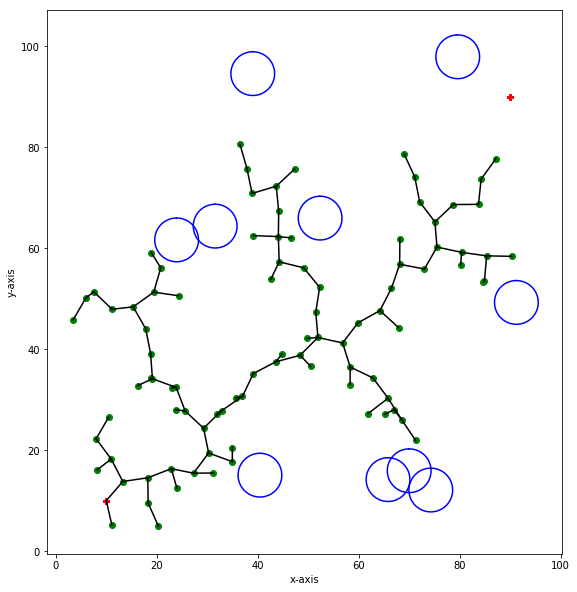

In [19]:
max_iter = 100
epsilon = 5 # step size

flag = 0 # for finding a connectivity path

# initial and goal points/states
x0 = 10
y0 = 10
x_goal = 90
y_goal = 90
plt.figure(figsize=[10,10])
plt.scatter([x0,x_goal],[y0,y_goal],c='r',marker="P")

# obstacle info
noo = 10 # no. of obstacles
radius = np.sqrt(3)/2*epsilon
obs_radii = radius*np.ones(noo)
obs_coors = 100*np.random.rand(2,noo) # position of obstacles
for i in range(0,noo):
    draw_circle(obs_coors[0,i],obs_coors[1,i],obs_radii[i])

if euc_distance_2d(x0,y0,x_goal,y_goal)<epsilon:
    flag = 1
    plt.plot([x0,x_goal],[y0,y_goal],c='black')
else:
    x = np.zeros(max_iter+1)
    y = np.zeros(max_iter+1)
    vertices = np.zeros([2,max_iter+1])
    A = -np.ones([max_iter+1,max_iter+1])
    x[0] = x0;
    y[0] = y0;
    vertices[0,0] = x[0]
    vertices[1,0] = y[0]
    A[0,0] = 0
    
nov = 0 # no. of vertices except the initial one

i = 0
while flag==0 and i<max_iter:
    i += 1
    x_rand= 100*np.random.rand(1)
    y_rand= 100*np.random.rand(1)
    [min_dis,p_near] = nearest_neighbor_2d(x_rand,y_rand,vertices,nov+1)
    if min_dis<epsilon:
        x_new = x_rand
        y_new = y_rand
    else: # interpolate
        r = epsilon/min_dis # ratio
        x_new = vertices[0,p_near]+r*(x_rand-vertices[0,p_near])
        y_new = vertices[1,p_near]+r*(y_rand-vertices[1,p_near])
    if collision_check(x_new,y_new,obs_coors,obs_radii,epsilon):
        nov = nov+1
        vertices[0,nov] = x_new
        vertices[1,nov] = y_new
        plt.scatter(x_new,y_new,c='g')
        plt.plot([vertices[0,p_near],x_new],[vertices[1,p_near],y_new],c='black')
        A[nov,:] = A[p_near,:]
        A[nov,nov] = nov
        if euc_distance_2d(x_new,y_new,x_goal,y_goal)<epsilon:
            nov = nov+1
            A[nov,:] = A[nov-1,:]
            A[nov,nov] = nov
            vertices[0,nov] = x_goal
            vertices[1,nov] = y_goal
            plt.plot([x_new,x_goal],[y_new,y_goal],c='black')
            flag = 1

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('scaled')

if flag ==1 and nov!=0:
    B = np.zeros(nov)
    nov_path =0 # no. of vertices on the connectivity path
    for i in range(0,nov+1):
        if A[nov,i]>-1:
            B[nov_path]=A[nov,i]
            nov_path += 1
    B = B[0:nov_path]
    for i in range(0, B.size-1):
        plt.plot([vertices[0,int(B[i])],vertices[0,int(B[i+1])]],[vertices[1,int(B[i])],vertices[1,int(B[i+1])]],c='yellow',linewidth=7,alpha=0.5)
elif flag ==0:
    print('No solution has been found for the given maximum number of iterations.')
else:
    print('The initial and goal configurations are close enough.')
    plt.plot([x0,x_goal],[y0,y_goal],c='yellow',linewidth=7,alpha=0.5)
# plt.savefig('the_basic.png')